# Metabolite MR

In [1]:
library(readr)
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(purrr)
library(ggplot2)

## SNPs in the reference panel

In [2]:
freq_1kg <- read_tsv("~/projects/DVA/Data/ReferenceData/1kg.afreq",
                     skip = 1,
                     col_names = c("chr", "position", "rsid", "nea_1kg_plus", "ea_1kg_plus", "eaf_1kg"),
                     col_types = "nncccn")

In [3]:
head(freq_1kg)

chr,position,rsid,nea_1kg_plus,ea_1kg_plus,eaf_1kg
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
1,11008,rs575272151,C,G,0.0884692
1,11012,rs544419019,C,G,0.0884692
1,13110,rs540538026,G,A,0.0566600
1,13116,rs62635286,T,G,0.1868790
1,13118,rs200579949,A,G,0.1868790
1,13273,rs531730856,G,C,0.1471170


## Outcome data

In [4]:
outcome_data <- read_tsv("~/projects/DVA/Data/GWAS_sumstats/t2d_diagram.txt",
                         skip = 1,
                         col_names = c("chrompos", 
                                       paste(c("ea", "nea", "beta", "se", "pval", "n"),
                                             "t2d",
                                             sep = "_")),
                         col_types = "cccnnnn")
head(outcome_data)

chrompos,ea_t2d,nea_t2d,beta_t2d,se_t2d,pval_t2d,n_t2d
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5:85928892,T,C,-0.0130,0.026,0.61,158186
11:107819621,A,C,-0.0710,0.170,0.67,124696
10:128341232,T,C,0.0140,0.012,0.24,158186
1:209652100,T,C,0.1500,0.130,0.25,131539
18:51112281,T,C,-0.0085,0.013,0.53,158184
4:55643311,T,C,-0.0060,0.016,0.71,158185


In [5]:
outcome_data <- outcome_data %>%
    mutate(chr = as.numeric(gsub("(^[0-9]+):.*$", "\\1", chrompos)),
           position = as.numeric(gsub("^[0-9]+:(.*$)", "\\1", chrompos)),
           chrompos = NULL) %>%
    inner_join(freq_1kg, by = c("chr", "position")) %>%
    # Strand alignment
    mutate(
        ea_1kg_minus = stringr::str_replace_all(ea_1kg_plus, c("A" = "t", "T" = "a", "C" = "g", "G" = "c")),
        ea_1kg_minus = toupper(ea_1kg_minus),
        nea_1kg_minus = stringr::str_replace_all(nea_1kg_plus, c("A" = "t", "T" = "a", "C" = "g", "G" = "c")),
        nea_1kg_minus = toupper(nea_1kg_minus),
        harmon = case_when(ea_t2d == ea_1kg_plus & nea_t2d == nea_1kg_plus ~ 1,
                           ea_t2d == ea_1kg_minus & nea_t2d == nea_1kg_minus ~ 1,
                           ea_t2d == nea_1kg_plus & nea_t2d == ea_1kg_plus ~ -1,
                           ea_t2d == nea_1kg_minus & nea_t2d == ea_1kg_minus ~ -1,
                           TRUE ~ 0)
    ) %>%
    filter(harmon != 0) %>%
    select(-c(harmon, ea_1kg_plus, ea_1kg_minus, nea_1kg_plus, ea_1kg_minus)) %>%
    # Ambiguous palindromic SNPs
    mutate(maf_1kg = ifelse(eaf_1kg < .5, eaf_1kg, 1 - eaf_1kg),
           palind_1 = ea_t2d %in% c("A", "T") & nea_t2d %in% c("A", "T"),
           palind_2 = ea_t2d %in% c("C", "G") & nea_t2d %in% c("C", "G"),
           palind_ambig = (palind_1 | palind_2) & maf_1kg > .4) %>%
    filter(!palind_ambig) %>%
    select(-starts_with("palind"), -eaf_1kg)
head(outcome_data)

ea_t2d,nea_t2d,beta_t2d,se_t2d,pval_t2d,n_t2d,chr,position,rsid,nea_1kg_minus,maf_1kg
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
T,C,-0.0130,0.026,0.61,158186,5,85928892,rs113534962,G,0.0626243
T,C,0.0140,0.012,0.24,158186,10,128341232,rs2366866,A,0.4592450
T,C,-0.0085,0.013,0.53,158184,18,51112281,rs62099898,A,0.2624250
T,C,-0.0060,0.016,0.71,158185,4,55643311,rs11725240,G,0.1640160
T,G,-0.0390,0.029,0.17,158184,1,4429872,rs72631092,C,0.0497018
A,C,-0.0080,0.016,0.62,158186,5,58252088,rs10069993,T,0.1590460


## Exposures data

Based on comparing concordant and discordant SNPs:

In [6]:
metabolite_ins <- read_tsv("../data/metabolite_ins.tsv", 
                           col_types = "nnnnnnccccnc")
head(metabolite_ins)

p,chr,se,beta,n,position,id,rsid,ea,nea,eaf,trait
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1.80011e-21,1,0.00774462,-0.0741187,NA,109784082,met-d-Total_C,rs61799430,A,G,0.072123,Total cholesterol
5.49997e-10,1,0.01096950,0.0674178,NA,109794252,met-d-Total_C,rs454107,C,T,0.965623,Total cholesterol
2.09991e-24,1,0.00406596,0.0414085,NA,109806442,met-d-Total_C,rs1337248,A,C,0.575821,Total cholesterol
4.49987e-17,1,0.00401884,0.0340888,NA,109807099,met-d-Total_C,rs6689614,A,G,0.461089,Total cholesterol
9.60064e-83,1,0.00480545,-0.0919129,NA,109817192,met-d-Total_C,rs7528419,G,A,0.222158,Total cholesterol
9.09913e-27,1,0.00699679,-0.0737643,NA,109819981,met-d-Total_C,rs55882046,T,C,0.089553,Total cholesterol


## Harmonization

In [7]:
validins_metab <- metabolite_ins %>%
    rename(pval = p) %>%
    rename_with(~paste(.x, "exp", sep = "_"), -c(chr, position, rsid, id, trait)) %>%
    mutate(maf_exp = ifelse(eaf_exp < .5, eaf_exp, 1 - eaf_exp)) %>%
    inner_join(outcome_data, by = c("chr", "position", "rsid")) %>%
    filter(abs(maf_exp - maf_1kg) < .2) %>%
    mutate(ea = ifelse(beta_exp > 0, ea_exp, nea_exp),
           nea = ifelse(beta_exp > 0, nea_exp, ea_exp),
           beta_exp = abs(beta_exp),
           harmon = case_when(ea_t2d == ea & nea_t2d == nea ~ 1,
                              ea_t2d == nea & nea_t2d == ea ~ -1,
                              TRUE ~ 0),
           ## If the alleles don't match, flipping strand
           across(c(ea_t2d, nea_t2d),
                  ~ifelse(harmon == 0,
                          toupper(stringr::str_replace_all(.x, c("A" = "t", "T" = "a", "C" = "g", "G" = "c"))),
                          .x)),
           ## Retesting with flipped alleles
           harmon = ifelse(harmon == 0,
                           case_when(ea == ea_t2d & nea == nea_t2d ~ 1,
                                     ea == nea_t2d & nea == ea_t2d ~ -1,
                                     TRUE ~ 0),
                           harmon),
           ## Aligning
           beta_t2d = beta_t2d * harmon) %>%
    ## Removing SNPs with allele mismatch
    filter(harmon != 0) %>%
    select(-c(harmon, ea_exp, nea_exp, ea_t2d, nea_t2d))
head(validins_metab)

pval_exp,chr,se_exp,beta_exp,n_exp,position,id,rsid,eaf_exp,trait,maf_exp,beta_t2d,se_t2d,pval_t2d,n_t2d,nea_1kg_minus,maf_1kg,ea,nea
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1.80011e-21,1,0.00774462,0.0741187,NA,109784082,met-d-Total_C,rs61799430,0.072123,Total cholesterol,0.072123,-0.0300,0.024,0.210,158184,C,0.0775348,G,A
5.49997e-10,1,0.01096950,0.0674178,NA,109794252,met-d-Total_C,rs454107,0.965623,Total cholesterol,0.034377,-0.0100,0.036,0.780,158184,A,0.0328030,C,T
2.09991e-24,1,0.00406596,0.0414085,NA,109806442,met-d-Total_C,rs1337248,0.575821,Total cholesterol,0.424179,-0.0290,0.013,0.020,158184,G,0.4105370,A,C
4.49987e-17,1,0.00401884,0.0340888,NA,109807099,met-d-Total_C,rs6689614,0.461089,Total cholesterol,0.461089,-0.0200,0.013,0.110,158184,C,0.4751490,A,G
9.60064e-83,1,0.00480545,0.0919129,NA,109817192,met-d-Total_C,rs7528419,0.222158,Total cholesterol,0.222158,-0.0260,0.015,0.074,158184,T,0.2127240,A,G
9.09913e-27,1,0.00699679,0.0737643,NA,109819981,met-d-Total_C,rs55882046,0.089553,Total cholesterol,0.089553,-0.0025,0.022,0.910,158184,G,0.0745527,C,T


## BMI

In [8]:
bmi <- read_tsv("~/projects/DVA/Data/GWAS_sumstats/bmi.txt", 
                skip = 1,
                col_names = c("chr", "position", "rsid", 
                              paste(c("ea", "nea", "eaf", "beta", "se", "pval", "n"), "bmi", sep = "_")),
                col_types = "nncccnnnnn")
head(bmi)

chr,position,rsid,ea_bmi,nea_bmi,eaf_bmi,beta_bmi,se_bmi,pval_bmi,n_bmi
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7,92383888,rs10,A,C,0.06431,0.0013,0.0042,0.7500,598895
12,126890980,rs1000000,A,G,0.22190,0.0001,0.0021,0.9600,689928
4,21618674,rs10000010,T,C,0.50860,-0.0001,0.0016,0.9400,785319
4,1357325,rs10000012,C,G,0.86340,0.0047,0.0025,0.0570,692463
4,37225069,rs10000013,A,C,0.77080,-0.0061,0.0021,0.0033,687856
4,84778125,rs10000017,T,C,0.22840,0.0041,0.0021,0.0480,686123


## Valid instruments

In [9]:
validins_bmi <- bmi %>%
    filter(pval_bmi < 5e-8) %>%
    mutate(maf_bmi = ifelse(eaf_bmi < .5, eaf_bmi, 1 - eaf_bmi),
           new_ea = ifelse(beta_bmi > 0, ea_bmi, nea_bmi),
           new_nea = ifelse(beta_bmi > 0, nea_bmi, ea_bmi),
           beta_bmi = abs(beta_bmi)) %>%
    select(-c(ea_bmi, nea_bmi)) %>%
    inner_join(validins_metab, by = c("chr", "position", "rsid")) %>%
    filter(abs(maf_bmi - maf_1kg) < .2) %>%
    ## Aligning to the BMI increasing allele
    mutate(harmon = case_when(ea == new_ea & nea == new_nea ~ 1,
                              ea == new_nea & nea == new_ea ~ -1,
                              TRUE ~ 0),
           ## If the alleles don't match, flipping strand
           across(c(ea, nea),
                  ~ifelse(harmon == 0,
                          toupper(stringr::str_replace_all(.x, c("A" = "t", "T" = "a", "C" = "g", "G" = "c"))),
                          .x)),
           ## Retesting with flipped alleles
           harmon = ifelse(harmon == 0,
                           case_when(ea == new_ea & nea == new_nea ~ 1,
                                     ea == new_nea & nea == new_ea ~ -1,
                                     TRUE ~ 0),
                           harmon),
           ## Aligning
           beta_exp = beta_exp * harmon,
           beta_t2d = beta_t2d * harmon,
           ea = new_ea, nea = new_nea) %>%
    ## Removing SNPs with allele mismatch
    filter(harmon != 0) %>%
    select(-c(harmon, new_ea, new_nea))
head(validins_bmi)

chr,position,rsid,eaf_bmi,beta_bmi,se_bmi,pval_bmi,n_bmi,maf_bmi,pval_exp,⋯,trait,maf_exp,beta_t2d,se_t2d,pval_t2d,n_t2d,nea_1kg_minus,maf_1kg,ea,nea
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
11,118913993,rs1003081,0.4497,0.0121,0.0016,1.3e-13,788712,0.4497,1.50000e-08,⋯,Free cholesterol to total lipids ratio in medium HDL,0.454878,0.019,0.013,0.12,152598,G,0.397614,T,C
11,118913993,rs1003081,0.4497,0.0121,0.0016,1.3e-13,788712,0.4497,1.60000e-08,⋯,HDL cholesterol,0.454878,0.019,0.013,0.12,152598,G,0.397614,T,C
11,118913993,rs1003081,0.4497,0.0121,0.0016,1.3e-13,788712,0.4497,1.60000e-08,⋯,Free cholesterol in HDL,0.454878,0.019,0.013,0.12,152598,G,0.397614,T,C
11,118913993,rs1003081,0.4497,0.0121,0.0016,1.3e-13,788712,0.4497,2.59998e-08,⋯,Cholesteryl esters in HDL,0.454878,0.019,0.013,0.12,152598,G,0.397614,T,C
5,74717653,rs10038723,0.2066,0.0244,0.0020,1.9e-34,795259,0.2066,2.09991e-29,⋯,Total cholesterol,0.210693,0.017,0.015,0.25,158186,G,0.220676,C,T
5,74717653,rs10038723,0.2066,0.0244,0.0020,1.9e-34,795259,0.2066,1.80011e-13,⋯,Cholesterol to total lipids ratio in large HDL,0.210693,0.017,0.015,0.25,158186,G,0.220676,C,T


## Clumping to obtain independent instruments

In [10]:
clump_fx <- function(rsid, pval, 
                     plink = "/ludc/Tools/Software/Plink/v1.90b5.2/plink", 
                     bfile = "/ludc/Home/daniel_c/projects/DVA/Data/ReferenceData/1kg_ref/EUR",
                     clump_p = 5e-8, clump_kb = 500, clump_r2 = 0.01){
    fn <- tempfile()
    dat <- data.frame(SNP = rsid, P = pval)
    write_tsv(dat, fn)
    plink_cmd <- paste0(plink,
                        " --bfile ", bfile,
                        " --clump ", fn, 
                        " --clump-p1 ", clump_p, 
                        " --clump-r2 ", clump_r2,
                        " --clump-kb ", clump_kb, 
                        " --out ", fn)
    system(plink_cmd)
    clumped_snps <- paste("awk '{print $3}'", paste(fn, "clumped", sep = ".")) %>%
        pipe %>%
        readLines
    unlink(paste0(fn, "*"))
    return(clumped_snps)
}

In [11]:
indins_metab <- validins_bmi %>%
    group_by(trait) %>%
    group_modify(~{
        snps_to_retain <- clump_fx(.x$rsid, .x$pval_exp)
        clumped_dat <- filter(.x, rsid %in% snps_to_retain)
    }) %>%
    ungroup
head(indins_metab)

trait,chr,position,rsid,eaf_bmi,beta_bmi,se_bmi,pval_bmi,n_bmi,maf_bmi,⋯,eaf_exp,maf_exp,beta_t2d,se_t2d,pval_t2d,n_t2d,nea_1kg_minus,maf_1kg,ea,nea
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
Alanine,2,211540507,rs1047891,0.3218,0.0141,0.0018,2.0e-15,774027,0.3218,⋯,0.315002,0.315002,-0.0012,0.014,0.930,158186,G,0.301193,A,C
Alanine,16,69549749,rs11866219,0.4022,0.0184,0.0018,3.1e-25,674474,0.4022,⋯,0.584248,0.415752,0.0210,0.013,0.094,158182,T,0.439364,A,C
Alanine,2,27730940,rs1260326,0.4027,0.0105,0.0017,3.9e-10,784462,0.4027,⋯,0.603981,0.396019,0.0290,0.013,0.021,158186,A,0.410537,C,T
Alanine,4,89181841,rs17789027,0.5922,0.0107,0.0018,1.6e-09,684237,0.4078,⋯,0.412833,0.412833,0.0260,0.012,0.035,158185,T,0.437376,G,A
Alanine,16,70104916,rs1833930,0.7751,0.0142,0.0021,6.2e-12,691776,0.2249,⋯,0.779612,0.220388,-0.0006,0.016,0.970,156032,C,0.209742,C,G
Alanine,12,122631208,rs2017594,0.7983,0.0131,0.0022,3.5e-09,679099,0.2017,⋯,0.804459,0.195541,0.0019,0.016,0.910,152596,C,0.219682,T,G


In [28]:
options(repr.plot.width = 10, repr.plot.height = 10)
ins_metab_res <- indins_metab %>%
    group_by(trait, sign_exp = sign(beta_exp)) %>%
    group_modify(
        ~{
            res <- meta::metagen(TE = beta_t2d, seTE = se_t2d, data = .x,
                                 fixed = FALSE, random = TRUE,
                                 method.tau = "PM", prediction = FALSE)
            with(res,
                 data.frame(b_meta = TE.random, se_meta = seTE.random,
                            conf_low_meta = lower.random, conf_high_meta = upper.random,
                            p_meta = pval.random, Qv = Q, Qdf = df.Q, Qp = pval.Q, Tau = tau, nsnp = nrow(.x)))
        }
    ) %>%
    ungroup
head(ins_metab_res)

trait,sign_exp,b_meta,se_meta,conf_low_meta,conf_high_meta,p_meta,Qv,Qdf,Qp,Tau,nsnp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Alanine,-1,-0.017109974,0.026048057,-0.0681632282,0.03394328,0.5112697697,120.005514,6,1.625247e-23,0.06720758,7
Alanine,1,0.011129087,0.010171450,-0.0088065897,0.03106476,0.2738894417,7.368827,3,6.102638e-02,0.01503882,4
Apolipoprotein A1,-1,0.019909575,0.009664256,0.0009679816,0.03885117,0.0393865931,22.112701,8,4.711312e-03,0.02370386,9
Apolipoprotein A1,1,0.010403552,0.023503301,-0.0356620706,0.05646918,0.6580245699,39.440525,5,1.936106e-07,0.05397693,6
Average diameter for LDL particles,-1,0.061689288,0.018395585,0.0256346039,0.09774397,0.0007980121,13.239890,3,4.145531e-03,0.02913610,4
Average diameter for LDL particles,1,0.002336648,0.017479012,-0.0319215860,0.03659488,0.8936531856,38.825649,4,7.568688e-08,0.03699565,5


In [36]:
ins_metab_res %>%
    filter(b_meta < 0 & p_meta < .05)

trait,sign_exp,b_meta,se_meta,conf_low_meta,conf_high_meta,p_meta,Qv,Qdf,Qp,Tau,nsnp
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Free cholesterol to total lipids ratio in medium HDL,1,-0.01444225,0.007179541,-0.02851389,-0.0003706097,0.044263783,17.0876818,8,0.0292089,0.01652356,9
Total concentration of lipoprotein particles,1,-0.02021882,0.007297372,-0.03452141,-0.0059162317,0.005593619,0.3468983,2,0.8407599,0.00000000,3


In [37]:
write_tsv(ins_metab_res, "../data/ins_metab_res.tsv")

In [35]:
ins_metab_res %>%
    transmute(trait, sign_exp = ifelse(sign_exp > 0, "pos", "neg"), 
              across(c(b_meta, conf_low_meta, conf_high_meta), format, digits = 2, decimal.mark = ","),
              p_meta = format(signif(p_meta, 3), decimal.mark = ","), nsnp) %>%
    pivot_wider(names_from = sign_exp, values_from = c(contains("meta"), nsnp)) %>%
    select(trait, contains("pos"), contains("neg")) %>%
    kableExtra::kbl("html", escape = FALSE,
                    col.names = c("Trait", rep(c("Beta", "Lower bound", "Upper bound", "<i>P</i>-value", "N SNPs"), 2))) %>%
    kableExtra::add_header_above(c(" " = 1, "High BMI - High trait" = 5, "High BMI - Low trait" = 5)) %>%
    as.character %>%
    IRdisplay::display_html()

High BMI - High trait 
 High BMI - Low trait 
 
 
 Trait 
 Beta 
 Lower bound 
 Upper bound 
 P -value 
 N SNPs 
 Beta 
 Lower bound 
 Upper bound 
 P -value 
 N SNPs 
 
 
 
 
 Alanine 
 0,01113 
 -0,00881 
 0,03106 
 0,274000 
 4 
 -0,01711 
 -0,06816 
 0,03394 
 0,511000 
 7 
 
 
 Apolipoprotein A1 
 0,01040 
 -0,03566 
 0,05647 
 0,658000 
 6 
 0,01991 
 0,00097 
 0,03885 
 0,039400 
 9 
 
 
 Average diameter for LDL particles 
 0,00234 
 -0,03192 
 0,03659 
 0,894000 
 5 
 0,06169 
 0,02563 
 0,09774 
 0,000798 
 4 
 
 
 Cholesterol in medium HDL 
 0,00644 
 -0,03437 
 0,04725 
 0,757000 
 7 
 0,01887 
 0,00147 
 0,03627 
 0,033500 
 9 
 
 
 Cholesterol in very large HDL 
 -0,01019 
 -0,02606 
 0,00569 
 0,209000 
 16 
 0,02367 
 0,00557 
 0,04177 
 0,010400 
 13 
 
 
 Cholesterol to total lipids ratio in large HDL 
 -0,00333 
 -0,01942 
 0,01277 
 0,685000 
 14 
 0,03095 
 0,01512 
 0,04679 
 0,000128 
 14 
 
 
 Cholesterol to total lipids ratio in large LDL 
 0,00546 
 -0,02048 
 0,03140 
 0,680000 
 6 
 0,02521 
 0,00820 
 0,04221 
 0,003680 
 15 
 
 
 Cholesterol to total lipids ratio in medium LDL 
 0,01028 
 -0,01691 
 0,03747 
 0,459000 
 4 
 0,02888 
 0,00681 
 0,05095 
 0,010300 
 5 
 
 
 Cholesterol to total lipids ratio in small LDL 
 0,05100 
 0,00788 
 0,09412 
 0,020400 
 1 
 0,02427 
 -0,00447 
 0,05300 
 0,097900 
 5 
 
 
 Cholesterol to total lipids ratio in small VLDL 
 0,01659 
 0,00167 
 0,03150 
 0,029300 
 10 
 0,03910 
 0,00143 
 0,07678 
 0,041900 
 6 
 
 
 Cholesterol to total lipids ratio in very small VLDL 
 0,00337 
 -0,01248 
 0,01921 
 0,677000 
 14 
 0,03961 
 0,01808 
 0,06115 
 0,000311 
 10 
 
 
 Cholesteryl esters in HDL 
 -0,00656 
 -0,03012 
 0,01700 
 0,585000 
 11 
 0,01946 
 0,00656 
 0,03236 
 0,003110 
 15 
 
 
 Cholesteryl esters in medium VLDL 
 -0,01445 
 -0,04633 
 0,01743 
 0,374000 
 5 
 0,05213 
 0,01436 
 0,08991 
 0,006830 
 5 
 
 
 Cholesteryl esters in very large HDL 
 -0,01019 
 -0,02606 
 0,00569 
 0,209000 
 16 
 0,02644 
 0,00997 
 0,04291 
 0,001650 
 15 
 
 
 Cholesteryl esters to total lipids ratio in large HDL 
 -0,00897 
 -0,02811 
 0,01018 
 0,359000 
 11 
 0,03608 
 0,01756 
 0,05459 
 0,000134 
 11 
 
 
 Cholesteryl esters to total lipids ratio in small VLDL 
 0,02221 
 0,00833 
 0,03609 
 0,001710 
 9 
 0,03905 
 0,00134 
 0,07677 
 0,042400 
 6 
 
 
 Concentration of HDL particles 
 0,01089 
 -0,05200 
 0,07378 
 0,734000 
 4 
 0,02349 
 0,00522 
 0,04177 
 0,011800 
 10 
 
 
 Concentration of very large HDL particles 
 -0,01128 
 -0,03254 
 0,00997 
 0,298000 
 12 
 0,02225 
 0,00442 
 0,04008 
 0,014500 
 13 
 
 
 Free cholesterol in HDL 
 -0,01370 
 -0,02799 
 0,00060 
 0,060400 
 9 
 0,02429 
 0,00639 
 0,04219 
 0,007830 
 9 
 
 
 Free cholesterol in IDL 
 -0,00733 
 -0,03490 
 0,02024 
 0,602000 
 7 
 0,04035 
 0,01179 
 0,06891 
 0,005630 
 7 
 
 
 Free cholesterol in medium HDL 
 0,00442 
 -0,03689 
 0,04574 
 0,834000 
 6 
 0,01451 
 -0,00839 
 0,03741 
 0,214000 
 8 
 
 
 Free cholesterol in very large HDL 
 -0,00194 
 -0,02324 
 0,01935 
 0,858000 
 12 
 0,03220 
 0,00911 
 0,05528 
 0,006270 
 9 
 
 
 Free cholesterol to total lipids ratio in IDL 
 0,00472 
 -0,02142 
 0,03087 
 0,723000 
 6 
 0,04994 
 0,01067 
 0,08921 
 0,012700 
 5 
 
 
 Free cholesterol to total lipids ratio in large HDL 
 0,00186 
 -0,02089 
 0,02461 
 0,873000 
 12 
 0,03651 
 0,00926 
 0,06376 
 0,008630 
 8 
 
 
 Free cholesterol to total lipids ratio in medium HDL 
 -0,01444 
 -0,02851 
 -0,00037 
 0,044300 
 9 
 0,02772 
 0,01044 
 0,04499 
 0,001660 
 15 
 
 
 Free cholesterol to total lipids ratio in medium VLDL 
 -0,00514 
 -0,03070 
 0,02042 
 0,693000 
 14 
 0,04917 
 0,00858 
 0,08976 
 0,017600 
 5 
 
 
 Free cholesterol to total lipids ratio in small VLDL 
 0,00347 
 -0,01089 
 0,01783 
 0,636000 
 17 
 0,05230 
 0,01828 
 0,08633 
 0,002590 
 6 
 
 
 Free cholesterol to total lipids ratio in very large VLDL 
 0,00226 
 -0,02383 
 0,02836 
 0,865000 
 10 
 0,0

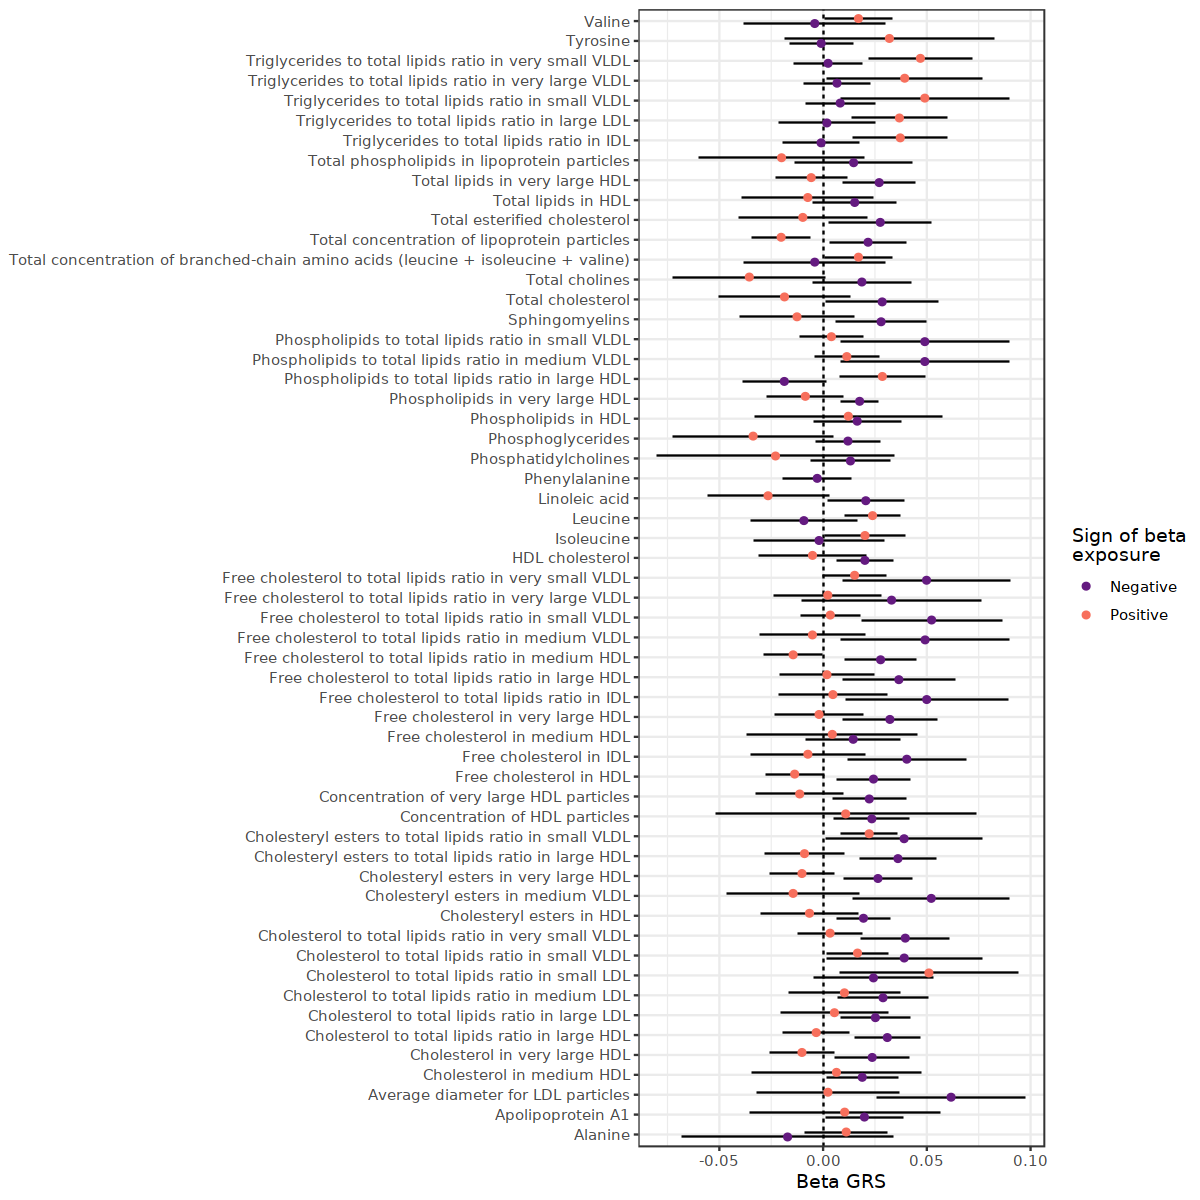

In [15]:
ins_metab_res %>%
    filter(trait != "Glucose") %>%
    mutate(sign_exp = ifelse(sign_exp > 0, "Positive", "Negative")) %>%
    ggplot(aes(b_meta, trait)) +
    geom_vline(xintercept = 0, lty = "dashed") +
    geom_linerange(aes(xmin = conf_low_meta, xmax = conf_high_meta, group = sign_exp),
                   position = position_dodge(width = .5)) +
    geom_point(aes(group = sign_exp, color = sign_exp), position = position_dodge(width = .5)) +
    scale_color_viridis_d(begin = .3, end = .7, option = "A") +
    theme_bw() +
    labs(x = "Beta GRS", y = NULL, color = "Sign of beta\nexposure")